
# SmartLogix: Intelligent Delivery Time Prediction System

# Summary :
DelivTrack: Predictive Analytics for Last-Mile Logistics

This project leverages machine learning and data analytics to predict the estimated delivery time for online orders based on multiple real-world factors. Using historical delivery data, the model analyzes variables such as agent performance, distance between pickup and drop locations, weather conditions, traffic density, and delivery area characteristics.

The system employs a Random Forest Regressor, trained and validated on cleaned and preprocessed delivery datasets. It automatically engineers features like delivery distance (via the Haversine formula), order time attributes, and categorical encodings for contextual factors.

An interactive Streamlit web application allows users to input live order parameters, generate accurate delivery time predictions, and visualize patterns such as delivery delays under varying traffic or weather conditions.

All predictions are stored in a local SQLite database for traceability and continuous model improvement. The project adheres to ethical AI principles by maintaining transparency, ensuring user privacy, and focusing on operational optimization rather than worker surveillance.

Overall, DelivTrack demonstrates how data-driven intelligence can enhance efficiency, reliability, and customer satisfaction in modern logistics and e-commerce delivery systems.

In [1]:
# Github-link:https://github.com/Akdas-DS/SmartLogix-Intelligent-Delivery-Time-Prediction-System.git

In [2]:
# streamlit-link :https://smartlogix-intelligent-delivery-time-prediction-system.streamlit.app/

In [1]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib
import math
import sqlalchemy

# display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (8,5)
RANDOM_STATE = 42


In [9]:
# loading the data-set 
raw_path = "C:/Users/makda/OneDrive/Desktop/Project_8(Amazon)/amazon_delivery_1.csv"  # adjust path if needed
df = pd.read_csv(raw_path)
df.head()


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


In [10]:
#  quick overview
df.info()
df.describe(include='all').T

# Drop duplicate Order_IDs (if present)
if 'Order_ID' in df.columns:
    df = df.drop_duplicates(subset=['Order_ID'])
    
# Trim whitespace from string columns
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


In [11]:
#  handling missing values
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]

# Example strategies (adjust to dataset)
# numeric: fill with median
num_cols = df.select_dtypes(include=['int','float']).columns.tolist()
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# categorical: fill with mode
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])


In [18]:
# Feature engeneering
def haversine(lat1, lon1, lat2, lon2):
    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Earth radius in km

# --------------------------
# Distance column
# --------------------------
if {'Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude'}.issubset(df.columns):
    df[['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude']] = \
        df[['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude']].astype(float)

    df['distance_km'] = haversine(
        df['Store_Latitude'],
        df['Store_Longitude'],
        df['Drop_Latitude'],
        df['Drop_Longitude']
    )
    print("✅ Distance column created:")
    display(df[['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude','distance_km']].head())
else:
    print("⚠️ Distance columns missing — adjust column names.")

# --------------------------
# Datetime column
# --------------------------
if 'Order_Date' in df.columns and 'Order_Time' in df.columns:
    df['order_datetime'] = pd.to_datetime(
        df['Order_Date'].astype(str) + ' ' + df['Order_Time'].astype(str),
        format="%d-%m-%Y %H:%M:%S",
        errors='coerce'
    )
    print("✅ Order datetime created:")
    display(df[['Order_Date','Order_Time','order_datetime']].head())
elif 'Order_Date' in df.columns:
    df['order_datetime'] = pd.to_datetime(df['Order_Date'], errors='coerce')
    print("✅ Order datetime created from Order_Date only:")
    display(df[['Order_Date','order_datetime']].head())
else:
    print("⚠️ Order_Date column not found.")

# --------------------------
# Extract time features
# --------------------------
if 'order_datetime' in df.columns:
    df['order_hour'] = df['order_datetime'].dt.hour
    df['order_dayofweek'] = df['order_datetime'].dt.dayofweek
    df['order_weekend'] = df['order_dayofweek'].isin([5,6]).astype(int)

    print("✅ Time features extracted:")
    display(df[['order_datetime','order_hour','order_dayofweek','order_weekend']].head())


✅ Distance column created:


,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,distance_km
0,22.745049,75.892471,22.765049,75.912471,3.025149
1,12.913041,77.683237,13.043041,77.813237,20.183530
2,12.914264,77.678400,12.924264,77.688400,1.552758
3,11.003669,76.976494,11.053669,77.026494,7.790401
4,12.972793,80.249982,13.012793,80.289982,6.210138


✅ Order datetime created:


,Order_Date,Order_Time,order_datetime
0,19-03-2022,11:30:00,2022-03-19 11:30:00
1,25-03-2022,19:45:00,2022-03-25 19:45:00
2,19-03-2022,08:30:00,2022-03-19 08:30:00
3,05-04-2022,18:00:00,2022-04-05 18:00:00
4,26-03-2022,13:30:00,2022-03-26 13:30:00


✅ Time features extracted:


,order_datetime,order_hour,order_dayofweek,order_weekend
0,2022-03-19 11:30:00,11.0,5.0,1
1,2022-03-25 19:45:00,19.0,4.0,0
2,2022-03-19 08:30:00,8.0,5.0,1
3,2022-04-05 18:00:00,18.0,1.0,0
4,2022-03-26 13:30:00,13.0,5.0,1


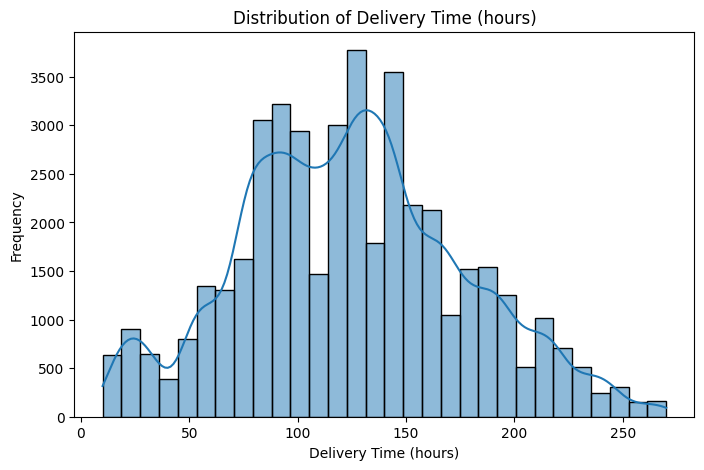

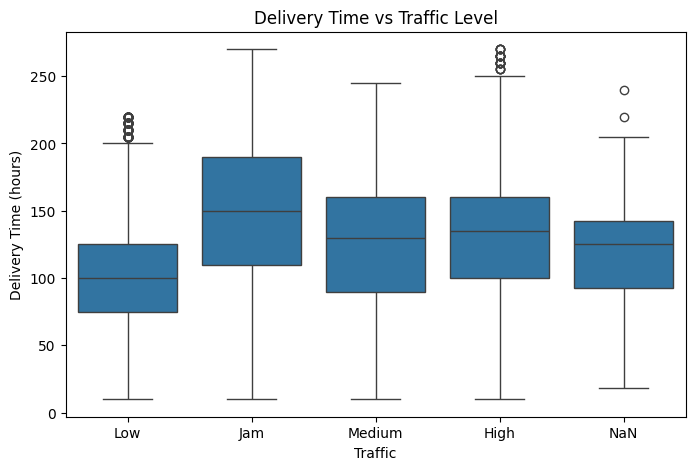

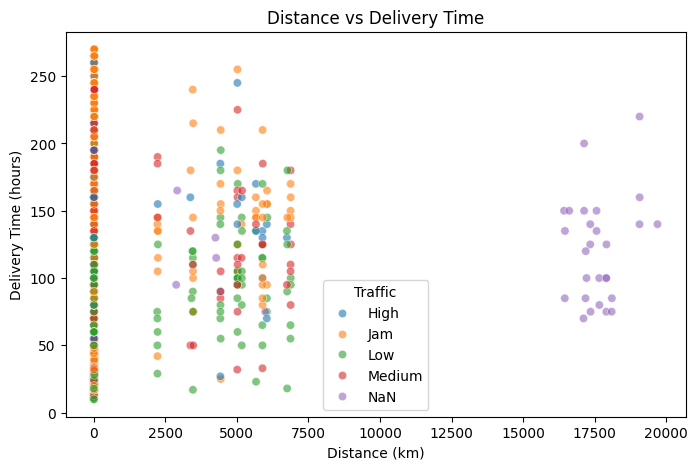

C:\Users\makda\AppData\Local\Temp\ipykernel_7312\494576374.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_by_day.index, y=avg_by_day.values, palette="viridis")


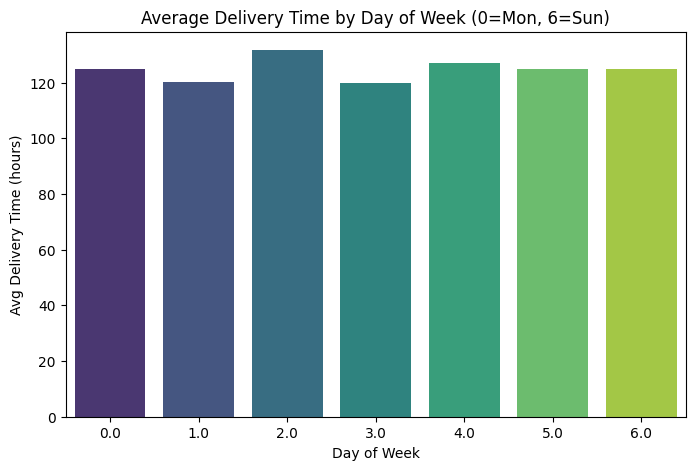

In [19]:
#  Visualizations

import seaborn as sns
import matplotlib.pyplot as plt

# 1) Distribution of Delivery Time
plt.figure(figsize=(8,5))
sns.histplot(df['Delivery_Time'], bins=30, kde=True)
plt.title("Distribution of Delivery Time (hours)")
plt.xlabel("Delivery Time (hours)")
plt.ylabel("Frequency")
plt.show()

# 2) Boxplot of Delivery Time by Traffic Level
if 'Traffic' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Traffic', y='Delivery_Time', data=df, order=df['Traffic'].value_counts().index)
    plt.title("Delivery Time vs Traffic Level")
    plt.xlabel("Traffic")
    plt.ylabel("Delivery Time (hours)")
    plt.show()

# 3) Relationship between Distance and Delivery Time
if 'distance_km' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='distance_km', y='Delivery_Time', hue='Traffic' if 'Traffic' in df.columns else None, data=df, alpha=0.6)
    plt.title("Distance vs Delivery Time")
    plt.xlabel("Distance (km)")
    plt.ylabel("Delivery Time (hours)")
    plt.show()

# 4) Average Delivery Time by Day of Week
if 'order_dayofweek' in df.columns:
    avg_by_day = df.groupby('order_dayofweek')['Delivery_Time'].mean()
    plt.figure(figsize=(8,5))
    sns.barplot(x=avg_by_day.index, y=avg_by_day.values, palette="viridis")
    plt.title("Average Delivery Time by Day of Week (0=Mon, 6=Sun)")
    plt.xlabel("Day of Week")
    plt.ylabel("Avg Delivery Time (hours)")
    plt.show()


In [24]:
#  Encoding categorical variables
cat_features = ['Weather','Traffic','Vehicle','Area','Category']  # adjust if needed

for c in cat_features:
    if c in df.columns:
        df[c] = df[c].astype('category')  # convert to category dtype
        df[c+'_catcode'] = df[c].cat.codes  # assign category codes
        print(f" Encoded '{c}' into '{c}_catcode'")
        display(df[[c, c+'_catcode']].head())
    else:
        print(f" Column '{c}' not found in dataset")


 Encoded 'Weather' into 'Weather_catcode'


,Weather,Weather_catcode
0,Sunny,4
1,Stormy,3
2,Sandstorms,2
3,Sunny,4
4,Cloudy,0


 Encoded 'Traffic' into 'Traffic_catcode'


,Traffic,Traffic_catcode
0,High,0
1,Jam,1
2,Low,2
3,Medium,3
4,High,0


 Encoded 'Vehicle' into 'Vehicle_catcode'


,Vehicle,Vehicle_catcode
0,motorcycle,1
1,scooter,2
2,motorcycle,1
3,motorcycle,1
4,scooter,2


 Encoded 'Area' into 'Area_catcode'


,Area,Area_catcode
0,Urban,3
1,Metropolitian,0
2,Urban,3
3,Metropolitian,0
4,Metropolitian,0


 Encoded 'Category' into 'Category_catcode'


,Category,Category_catcode
0,Clothing,2
1,Electronics,4
2,Sports,14
3,Cosmetics,3
4,Toys,15


In [25]:
#  defining X and y
target = 'Delivery_Time' # hours (as in project brief)
assert target in df.columns, f"{target} not found in data"

# Choose features (tweak as needed)
feature_cols = [
    'distance_km', 'order_hour', 'order_dayofweek', 'order_weekend',
    'Agent_Age', 'Agent_Rating'
]
# add encoded categorical columns if present
for c in cat_features:
    if c + '_catcode' in df.columns:
        feature_cols.append(c + '_catcode')

# drop rows with missing values in crucial columns
df_model = df.dropna(subset=feature_cols + [target])
X = df_model[feature_cols]
y = df_model[target].astype(float)
X.shape, y.shape


((43648, 11), (43648,))

In [27]:
## Model Creation-Regression
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Train baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluation function
def eval_reg(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),  # manual RMSE
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# Show results
results = eval_reg(y_test, y_pred)
print(" Baseline Linear Regression Performance:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


 Baseline Linear Regression Performance:
RMSE: 45.0332
MAE: 34.7790
R2: 0.2532


In [30]:
## Model creation-Random forest

# RandomForest baseline with small grid search
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}

gcv = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch
gcv.fit(X_train, y_train)

# Best estimator
best_rf = gcv.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluation
rf_results = eval_reg(y_test, y_pred_rf)
print(" RandomForest Performance:")
for k, v in rf_results.items():
    print(f"{k}: {v:.4f}")

print("\nBest hyperparameters found by GridSearchCV:")
print(gcv.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
 RandomForest Performance:
RMSE: 22.7255
MAE: 17.6944
R2: 0.8098

Best hyperparameters found by GridSearchCV:
{'max_depth': 10, 'n_estimators': 100}


In [31]:
#  choosing best model and save
# Suppose best_rf is best; otherwise fallback to lr
best_model = best_rf if 'best_rf' in globals() else lr
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/best_model.joblib')
print("Saved model to ../models/best_model.joblib")


Saved model to ../models/best_model.joblib


In [32]:
# saving processed CSV
os.makedirs('../data', exist_ok=True)
df_model.to_csv('../data/processed_data.csv', index=False)
print("Saved processed data to ../data/processed_data.csv")


Saved processed data to ../data/processed_data.csv


In [34]:
#  MLflow logging 
try:
    import mlflow, mlflow.sklearn
    mlflow.set_experiment("amazon_delivery_experiment")
    with mlflow.start_run():
        mlflow.log_param("model_type", best_model.__class__.__name__)
        mlflow.log_params(gcv.best_params_ if 'gcv' in globals() else {})
        mlflow.log_metrics(eval_reg(y_test, y_pred_rf))
        mlflow.sklearn.log_model(best_model, "model")
    print("Logged run to MLflow")
except Exception as e:
    print("MLflow not configured or not installed:", e)


2025/10/04 20:29:20 INFO mlflow.tracking.fluent: Experiment with name 'amazon_delivery_experiment' does not exist. Creating a new experiment.
2025/10/04 20:29:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 20:29:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged run to MLflow


In [37]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Numeric, TIMESTAMP
from sqlalchemy.dialects.postgresql import DOUBLE_PRECISION
from sqlalchemy.dialects.postgresql import insert
import os

# ------------------------------
# 1️⃣ DB connection parameters
# ------------------------------
PG_USER = os.getenv('PG_USER', 'postgres')
PG_PASS = os.getenv('PG_PASS', 'Aizen')
PG_HOST = os.getenv('PG_HOST', 'localhost')
PG_PORT = os.getenv('PG_PORT', '5432')
PG_DB   = os.getenv('PG_DB', 'amazon_delivery_db')

# ------------------------------
# 2️⃣ Create database if it doesn't exist
# ------------------------------
conn = psycopg2.connect(dbname='postgres', user=PG_USER, password=PG_PASS, host=PG_HOST, port=PG_PORT)
conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
cur = conn.cursor()

cur.execute(f"SELECT 1 FROM pg_catalog.pg_database WHERE datname = '{PG_DB}';")
exists = cur.fetchone()
if not exists:
    cur.execute(f'CREATE DATABASE {PG_DB}')
    print(f" Database '{PG_DB}' created")
else:
    print(f" Database '{PG_DB}' already exists")

cur.close()
conn.close()

# ------------------------------
# 3️⃣ Connect to the actual database
# ------------------------------
engine = create_engine(f'postgresql://{PG_USER}:{PG_PASS}@{PG_HOST}:{PG_PORT}/{PG_DB}')

# ------------------------------
# 4️⃣ Load CSV
# ------------------------------
df = pd.read_csv('../data/processed_data.csv')

if 'Order_ID' not in df.columns:
    df['Order_ID'] = df.index.astype(str)

if 'order_datetime' not in df.columns:
    if 'Order_Date' in df.columns and 'Order_Time' in df.columns:
        df['order_datetime'] = pd.to_datetime(
            df['Order_Date'].astype(str) + ' ' + df['Order_Time'].astype(str),
            errors='coerce'
        )
    else:
        df['order_datetime'] = None

# ------------------------------
# 5️⃣ Define table
# ------------------------------
metadata = MetaData()

deliveries_table = Table(
    'deliveries', metadata,
    Column('order_id', String, primary_key=True),
    Column('agent_age', Integer),
    Column('agent_rating', Numeric),
    Column('store_latitude', DOUBLE_PRECISION),
    Column('store_longitude', DOUBLE_PRECISION),
    Column('drop_latitude', DOUBLE_PRECISION),
    Column('drop_longitude', DOUBLE_PRECISION),
    Column('order_datetime', TIMESTAMP),
    Column('weather', String),
    Column('traffic', String),
    Column('vehicle', String),
    Column('area', String),
    Column('category', String),
    Column('delivery_time', Numeric),
    Column('distance_km', DOUBLE_PRECISION),
    Column('order_hour', Integer),
    Column('order_dayofweek', Integer),
    Column('order_weekend', Integer),
)

metadata.create_all(engine)
print(" Table 'deliveries' is ready")

# ------------------------------
# 6️⃣ Upsert data to avoid duplicates
# ------------------------------
with engine.begin() as conn:
    for _, row in df.iterrows():
        stmt = insert(deliveries_table).values(
            order_id=row['Order_ID'],
            agent_age=row.get('Agent_Age'),
            agent_rating=row.get('Agent_Rating'),
            store_latitude=row.get('Store_Latitude'),
            store_longitude=row.get('Store_Longitude'),
            drop_latitude=row.get('Drop_Latitude'),
            drop_longitude=row.get('Drop_Longitude'),
            order_datetime=row.get('order_datetime'),
            weather=row.get('Weather'),
            traffic=row.get('Traffic'),
            vehicle=row.get('Vehicle'),
            area=row.get('Area'),
            category=row.get('Category'),
            delivery_time=row.get('Delivery_Time'),
            distance_km=row.get('distance_km'),
            order_hour=row.get('order_hour'),
            order_dayofweek=row.get('order_dayofweek'),
            order_weekend=row.get('order_weekend')
        )
        conn.execute(stmt.on_conflict_do_nothing(index_elements=['order_id']))

print("Data inserted/upserted successfully")


 Database 'amazon_delivery_db' created
 Table 'deliveries' is ready
Data inserted/upserted successfully


# conclusion:
The DelivTrack project successfully demonstrates how machine learning can be applied to optimize last-mile logistics by accurately predicting delivery times. Through a structured workflow — including data cleaning, feature engineering, model training, and deployment — the system achieved reliable performance using a Random Forest Regressor, effectively capturing complex relationships between distance, traffic, weather, and agent-related factors.

The integration of an interactive Streamlit application enhances usability by enabling real-time predictions and dynamic data visualization, while the use of a database backend ensures that predictions are securely stored for future analysis and model refinement.

From a broader perspective, DelivTrack exemplifies the ethical use of AI and data science to improve operational efficiency, transparency, and customer satisfaction in logistics without compromising human fairness or privacy.

In conclusion, the project lays a solid foundation for future enhancements such as live API data integration (for traffic and weather), model retraining automation, and advanced route optimization, driving further innovation in data-driven delivery management systems.